In [1]:
import pandas as pd

# Load the dataset
train = pd.read_csv("../data/train.csv")

In [2]:
def transform_data(df:pd.DataFrame):
    # Now the names...
    # First, seperate the first and last name
    df[["LastName", "FirstName_tmp"]] = df["Name"].str.split(",", expand=True)
    
    # Now the salutation forms
    df[["SalutForm","FirstName"]] = df["FirstName_tmp"].str.split(".", n=1, expand=True)
    
    df = df.drop([
        "PassengerId",
        "FirstName_tmp",
        "FirstName",
        "LastName",
        "Name",
        "Cabin",
        "Ticket"],
        axis=1)
    return df

In [3]:
train = transform_data(train)

In [4]:
num_cols = ["Age", "SibSp", "Parch", "Fare"]
cat_cols = ["Pclass", "Sex", "Embarked", "SalutForm"]

In [5]:
# Define pipelines and preprocessor
from sklearn import (compose, impute, linear_model, preprocessing)
from sklearn.pipeline import Pipeline

numerical_preprocessor = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="mean")),
    ("scaler", preprocessing.StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="most_frequent")),
    ("onehot", preprocessing.OneHotEncoder(handle_unknown="error", sparse_output=False))
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ("numerical", numerical_preprocessor, num_cols),
        ("categorical", categorical_preprocessor, cat_cols),
    ]
)

In [6]:
# Split the data

y = train["Survived"]
X = train.drop(["Survived"], axis=1)

In [7]:
preprocessor.set_output(transform="pandas")
X_pipe = preprocessor.fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pipe, y, test_size=0.2)

In [9]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 205 to 299
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__Age                        179 non-null    float64
 1   numerical__SibSp                      179 non-null    float64
 2   numerical__Parch                      179 non-null    float64
 3   numerical__Fare                       179 non-null    float64
 4   categorical__Pclass_1                 179 non-null    float64
 5   categorical__Pclass_2                 179 non-null    float64
 6   categorical__Pclass_3                 179 non-null    float64
 7   categorical__Sex_female               179 non-null    float64
 8   categorical__Sex_male                 179 non-null    float64
 9   categorical__Embarked_C               179 non-null    float64
 10  categorical__Embarked_Q               179 non-null    float64
 11  categorical__Emba

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 652 to 362
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__Age                        712 non-null    float64
 1   numerical__SibSp                      712 non-null    float64
 2   numerical__Parch                      712 non-null    float64
 3   numerical__Fare                       712 non-null    float64
 4   categorical__Pclass_1                 712 non-null    float64
 5   categorical__Pclass_2                 712 non-null    float64
 6   categorical__Pclass_3                 712 non-null    float64
 7   categorical__Sex_female               712 non-null    float64
 8   categorical__Sex_male                 712 non-null    float64
 9   categorical__Embarked_C               712 non-null    float64
 10  categorical__Embarked_Q               712 non-null    float64
 11  categorical__Emba

In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

resampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

In [12]:
df = pd.concat([y_train, X_train], axis=1)
df["Survived"].value_counts()

0    433
1    279
Name: Survived, dtype: int64

In [21]:
df = pd.concat([y_train_resampled, X_train_resampled], axis=1)
df["Survived"].value_counts()

0    433
1    433
Name: Survived, dtype: int64

In [22]:
df = pd.concat([y_test, X_test], axis=1)
df["Survived"].value_counts()

0    116
1     63
Name: Survived, dtype: int64

# Test für den balancierten Datensatz

In [14]:
# Model Definition
from sklearn.linear_model import LogisticRegression

algo = LogisticRegression()


model = algo.fit(X_train_resampled, y_train_resampled)

In [23]:
def threshold_predict(model, X, threshold=0):
    y_predict = model.decision_function(X)
    y_alt_threshold_predict = (y_predict > threshold)
    return y_alt_threshold_predict.astype(int)

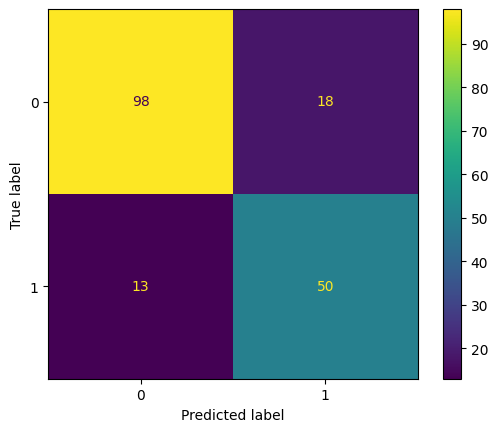

In [29]:
# Konfusionsmatrix und recall sowie precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0

y_test_predict = threshold_predict(model, X_test, threshold=threshold)
cm = confusion_matrix(y_test, y_test_predict)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: \t{accuracy_score(y_test, y_test_predict)}")
print(f"Precision: \t{precision_score(y_test, y_test_predict)}")
print(f"Recall: \t{recall_score(y_test, y_test_predict)}")
print(f"F1 Score: \t{f1_score(y_test, y_test_predict)}")

Accuracy: 	0.8268156424581006
Precision: 	0.7352941176470589
Recall: 	0.7936507936507936
F1 Score: 	0.7633587786259542


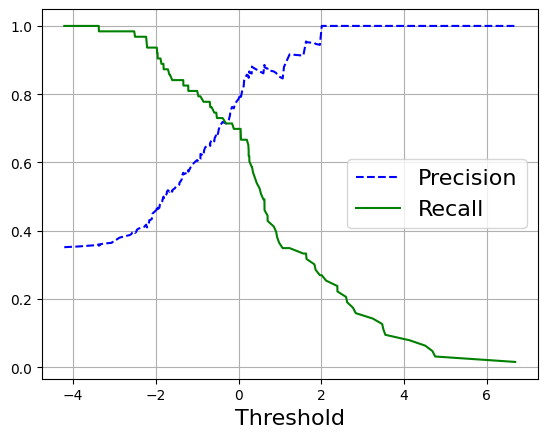

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(model, X_test, y_test, cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()